<a href="https://colab.research.google.com/github/Sounak97/Assignment-5/blob/Sounak97/Intro_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Intro to Neural Networks
Learning Objectives:

Define a neural network (NN) and its hidden layers using the TensorFlow DNNRegressor class
Train a neural network to learn nonlinearities in a dataset and achieve better performance than a linear regression model
In the previous exercises, we used synthetic features to help our model incorporate nonlinearities.

One important set of nonlinearities was around latitude and longitude, but there may be others.

We'll also switch back, for now, to a standard regression task, rather than the logistic regression task from the previous exercise. That is, we'll be predicting median_house_value directly.

In [0]:
#Standard Setup as in previous exrcises

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scaling
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
#First 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

#Last 5000 (out of 17000) examples for validation and thus maintaining a conventional ratio
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))


print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2630.6,537.9,1426.9,499.7,3.9,2.0
std,2.1,2.0,12.6,2166.1,420.7,1167.3,384.0,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1459.8,296.0,788.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2125.0,432.0,1167.0,408.0,3.5,1.9
75%,37.7,-118.0,37.0,3140.2,644.0,1713.0,600.0,4.7,2.3
max,42.0,-114.6,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.5,2675.0,543.0,1436.1,505.0,3.9,2.0
std,2.1,2.0,12.5,2212.6,423.4,1100.0,385.7,1.9,1.0
min,32.5,-124.3,1.0,11.0,3.0,8.0,2.0,0.5,0.2
25%,33.9,-121.8,18.0,1467.0,297.0,793.0,282.0,2.6,1.5
50%,34.2,-118.5,28.0,2140.5,437.0,1167.0,410.0,3.5,2.0
75%,37.7,-118.0,37.0,3184.0,662.0,1746.0,616.0,4.8,2.3
max,42.0,-114.3,52.0,27700.0,4457.0,15037.0,4204.0,15.0,26.5


Training targets summary:


,median_house_value
count,12000.0
mean,207.0
std,116.0
min,15.0
25%,119.3
50%,179.8
75%,264.9
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.1
std,116.0
min,15.0
25%,120.0
50%,181.3
75%,265.3
max,500.0


**Building a Neural Network**:
The NN is defined by the **DNNRegressor** class.

Using **hidden_units** to define the structure of the NN. The hidden_units argument provides a list of ints, where each int corresponds to a hidden layer and indicates the number of nodes in it. For example, consider the following assignment:

hidden_units=[3,10]

The preceding assignment specifies a neural net with two hidden layers:

The first hidden layer contains 3 nodes.
The second hidden layer contains 10 nodes.
If we wanted to add more layers, we'd add more ints to the list. For example, hidden_units=[10,20,30,40] would create four layers with ten, twenty, thirty, and forty units, respectively.

By default, all hidden layers will use ReLu activation and will be fully connected.

In [0]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
             for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural net regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Conversion pandas data into a dict of np arrays as done i  previous cases
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construction of a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) 
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `DNNRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  #DNNRegressor object
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer,
  )
  
 
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

 
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
   
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
   
    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
   
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
   
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
   
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

**Task 1: Train a NN Model**
Adjust hyperparameters, aiming to drop RMSE below 110.

Running the following block to train a NN model.

Recalling  that in the linear regression exercise with many features, an RMSE of 110 or so was pretty good. We'll aim to beat that.

Task here is to modify various learning settings to improve accuracy on validation data.

Overfitting is a real potential hazard for NNs. You can look at the gap between loss on training data and loss on validation data to help judge if your model is starting to overfit. If the gap starts to grow, that is usually a sure sign of overfitting.

Because of the number of different possible settings, it's strongly recommended that we take notes on each trial to help guide your development process.

Also, when you get a good setting, try running it multiple times and see how repeatable your result is. NN weights are typically initialized to small random values, so you should see differences from run to run.

Training model...
RMSE (on training data):
  period 00 : 172.37
  period 01 : 159.93
  period 02 : 151.13
  period 03 : 144.71
  period 04 : 135.88
  period 05 : 127.43
  period 06 : 121.93
  period 07 : 117.03
  period 08 : 112.37
  period 09 : 111.86
Model training finished.
Final RMSE (on training data):   111.86
Final RMSE (on validation data): 111.32


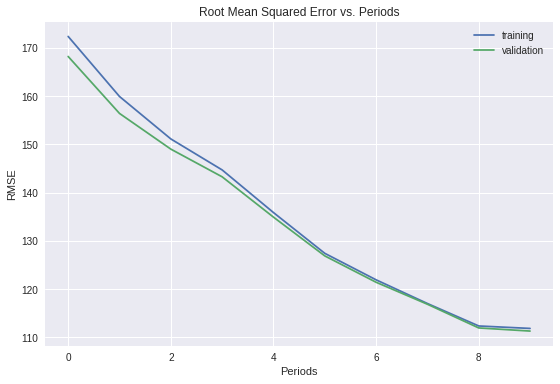

In [17]:
dnn_regressor=train_nn_regression_model(learning_rate=0.001,steps=2000,batch_size=100,hidden_units=[10,10],training_examples=training_examples,training_targets=training_targets,validation_examples=validation_examples,
                                                                           
                                        validation_targets=validation_targets)



**Task 2: Evaluation on Test Data**

In [18]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")
test_examples=preprocess_features(california_housing_test_data)
test_targets=preprocess_targets(california_housing_test_data)
predict_testing_input_fn=lambda:my_input_fn(test_examples,test_targets['median_house_value'],num_epochs=1,shuffle=False)
test_predictions = dnn_regressor.predict(input_fn=predict_testing_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])
root_mean_squared_error=math.sqrt(metrics.mean_squared_error(test_predictions,test_targets))
print("Final RMSE on test data: %0.2f" % root_mean_squared_error)

Final RMSE on test data: 110.39
